# 1차 모델 구축

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# SMOTE + 파이프라인 (imblearn)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
# 0. 데이터 불러오기
df = pd.read_csv("stroke.csv")

In [5]:
# 4-0 숫자형 변수 목록
num_cols = ["age", "avg_glucose_level", "bmi"]

# 4-0 범주형 변수 목록
cat_cols = ["gender", "hypertension", "heart_disease", 
            "ever_married", "work_type", "Residence_type", 
            "smoking_status"]

In [6]:
# 성인(adult) 그룹만 사용 (age >= 18)
adult_df = df[df["age"] >= 18].copy()

# 타깃 변수
target = "stroke"

# id 컬럼이 있으면 제거 (모델 학습에 필요 없음)
drop_cols = [target]
if "id" in adult_df.columns:
    drop_cols.append("id")

X = adult_df.drop(columns=drop_cols)
y = adult_df[target]

# 전처리 파이프라인
# - 숫자형: RobustScaler (이상치에 덜 민감)
# - 범주형: One-Hot 인코딩
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Train / Test 나누기 (성인 그룹 안에서만)-
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # 불균형 클래스 비율 유지
    random_state=42
)

In [7]:
# Random Forest 모델
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced_subsample",  # 불균형 보정
            n_jobs=-1
        ))
    ]
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("✅ Random Forest 성능 (성인 그룹)")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("-" * 60)

✅ Random Forest 성능 (성인 그룹)
              precision    recall  f1-score   support

           0      0.943     0.998     0.970       802
           1      0.333     0.020     0.038        49

    accuracy                          0.941       851
   macro avg      0.638     0.509     0.504       851
weighted avg      0.908     0.941     0.916       851

ROC-AUC: 0.7611710519619319
------------------------------------------------------------


# 1차 ROC 곡선

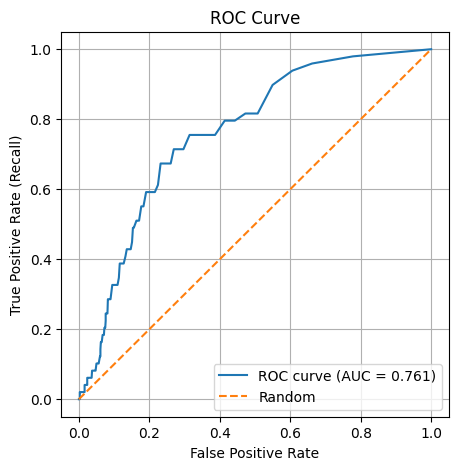

In [8]:
# y_test : 실제 레이블 (0/1)
# y_proba: 모델이 예측한 stroke=1 확률

# ROC 곡선 계산
# - fpr: False Positive Rate
# - tpr: True Positive Rate (= recall)
# - thresholds: 각 점에서의 decision 기준값
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 1차 threshold_recall = 0.80

In [9]:
# ROC 곡선에서 목표 recall(예: 0.8)에 가장 가까운 threshold 찾기
target_recall = 0.80

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_rf >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.80 에 가장 가까운 threshold
- threshold ≈ 0.027
- recall(=TPR) ≈ 0.796
- FPR ≈ 0.414

✅ 선택한 threshold에서 stroke=1 성능
- precision_1 = 0.105
- recall_1    = 0.796
- f1_1        = 0.186


# 1차 threshold_recall = 0.90

In [10]:
# ROC 곡선에서 목표 recall(예: 0.9)에 가장 가까운 threshold 찾기
target_recall = 0.90

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_rf >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.90 에 가장 가까운 threshold
- threshold ≈ 0.013
- recall(=TPR) ≈ 0.898
- FPR ≈ 0.550

✅ 선택한 threshold에서 stroke=1 성능
- precision_1 = 0.091
- recall_1    = 0.898
- f1_1        = 0.165


# 2차 모델 구축
## SMOTE 적용

In [13]:
# 성인(adult) 그룹만 사용 (age >= 18)
adult_df = df[df["age"] >= 18].copy()

target = "stroke"

# id 컬럼이 있으면 제거 (모델 학습에 필요 없는 식별자)
drop_cols = [target]
if "id" in adult_df.columns:
    drop_cols.append("id")

X = adult_df.drop(columns=drop_cols)
y = adult_df[target]

# 전처리 파이프라인
# - 숫자형: RobustScaler (이상치에 덜 민감)
# - 범주형: One-Hot 인코딩

preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Train / Test 나누기 (성인 그룹 안에서만)
# - SMOTE는 반드시 train에만 적용해야 하므로
#   split을 먼저 해주고, 파이프라인 안에서 train에만 적용되게 함
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # 불균형 비율 유지
    random_state=42
)

# SMOTE 설정 (소수 클래스 = stroke=1 을 synthetic하게 늘려주는 역할)
smote = SMOTE(random_state=42)

In [14]:
# Random Forest + SMOTE 파이프라인
rf_clf = ImbPipeline(
    steps=[
        ("preprocess", preprocess),   # 1) 전처리
        ("smote", smote),             # 2) SMOTE oversampling
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
            # SMOTE가 이미 데이터를 balance시키므로
            # 여기서는 class_weight를 기본값(None)으로 두고 시작
        ))
    ]
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("✅ Random Forest + SMOTE 성능 (성인 그룹)")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("-" * 60)

/home/kdt_43/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


✅ Random Forest + SMOTE 성능 (성인 그룹)
              precision    recall  f1-score   support

           0      0.946     0.955     0.950       802
           1      0.122     0.102     0.111        49

    accuracy                          0.906       851
   macro avg      0.534     0.529     0.531       851
weighted avg      0.898     0.906     0.902       851

ROC-AUC: 0.7453814443483129
------------------------------------------------------------


# 2차 ROC 곡선

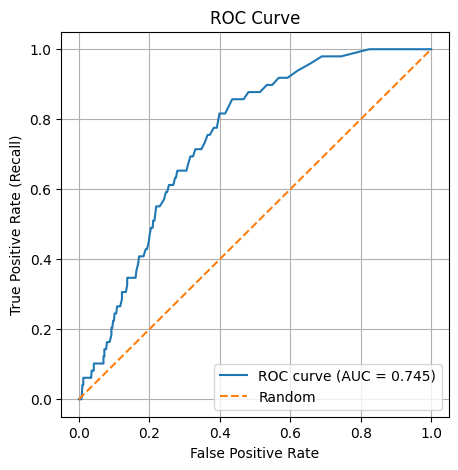

In [15]:
# y_test : 실제 레이블 (0/1)
# y_proba: 모델이 예측한 stroke=1 확률

# ROC 곡선 계산
# - fpr: False Positive Rate
# - tpr: True Positive Rate (= recall)
# - thresholds: 각 점에서의 decision 기준값
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 2차 threshold_recall = 0.80

In [16]:
# ROC 곡선에서 목표 recall(예: 0.8)에 가장 가까운 threshold 찾기
target_recall = 0.80

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_rf >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.80 에 가장 가까운 threshold
- threshold ≈ 0.067
- recall(=TPR) ≈ 0.816
- FPR ≈ 0.399

✅ 선택한 threshold에서 stroke=1 성능
- precision_1 = 0.111
- recall_1    = 0.816
- f1_1        = 0.196


# 2차 threshold_recall = 0.90

In [17]:
# ROC 곡선에서 목표 recall(예: 0.9)에 가장 가까운 threshold 찾기
target_recall = 0.90

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_rf >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.90 에 가장 가까운 threshold
- threshold ≈ 0.030
- recall(=TPR) ≈ 0.898
- FPR ≈ 0.534

✅ 선택한 threshold에서 stroke=1 성능
- precision_1 = 0.093
- recall_1    = 0.898
- f1_1        = 0.169


# 3차 모델 구축
## 전체 데이터 사용

In [18]:
target = "stroke"

drop_cols = [target]
if "id" in df.columns:   # id 컬럼 있으면 제거
    drop_cols.append("id")

X = df.drop(columns=drop_cols)
y = df[target]

# 전처리 파이프라인
# - 숫자형: RobustScaler
# - 범주형: One-Hot 인코딩
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Train / Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # stroke 비율 유지
    random_state=42
)

# SMOTE 설정 (소수 클래스 = stroke=1 증가)
smote = SMOTE(random_state=42)

In [19]:
# Random Forest + SMOTE (전체 데이터)
rf_clf = ImbPipeline(
    steps=[
        ("preprocess", preprocess),
        ("smote", smote),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("✅ Random Forest + SMOTE 성능 (전체 데이터)")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("-" * 60)

/home/kdt_43/miniconda3/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


✅ Random Forest + SMOTE 성능 (전체 데이터)
              precision    recall  f1-score   support

           0      0.956     0.968     0.962       972
           1      0.184     0.140     0.159        50

    accuracy                          0.928      1022
   macro avg      0.570     0.554     0.561      1022
weighted avg      0.919     0.928     0.923      1022

ROC-AUC: 0.7665432098765432
------------------------------------------------------------


# 3차 ROC 곡선

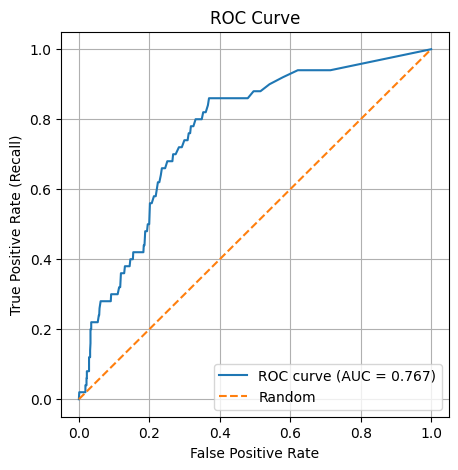

In [20]:
# y_test : 실제 레이블 (0/1)
# y_proba: 모델이 예측한 stroke=1 확률

# ROC 곡선 계산
# - fpr: False Positive Rate
# - tpr: True Positive Rate (= recall)
# - thresholds: 각 점에서의 decision 기준값
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 3차 threshold_recall = 0.80

In [21]:
# ROC 곡선에서 목표 recall(예: 0.8)에 가장 가까운 threshold 찾기
target_recall = 0.80

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_rf >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.80 에 가장 가까운 threshold
- threshold ≈ 0.077
- recall(=TPR) ≈ 0.800
- FPR ≈ 0.331

✅ 선택한 threshold에서 stroke=1 성능
- precision_1 = 0.110
- recall_1    = 0.800
- f1_1        = 0.194


# 3차 threshold_recall = 0.90

In [22]:
# ROC 곡선에서 목표 recall(예: 0.9)에 가장 가까운 threshold 찾기
target_recall = 0.90

# tpr(=recall)과 target_recall의 차이가 가장 작은 index 선택
best_idx = np.argmin(np.abs(tpr - target_recall))
best_thr = thresholds[best_idx]
best_recall = tpr[best_idx]
best_fpr = fpr[best_idx]

print(f"🎯 목표 recall {target_recall:.2f} 에 가장 가까운 threshold")
print(f"- threshold ≈ {best_thr:.3f}")
print(f"- recall(=TPR) ≈ {best_recall:.3f}")
print(f"- FPR ≈ {best_fpr:.3f}")

# 이 threshold로 최종 예측해보기
y_pred_best = (y_proba_rf >= best_thr).astype(int)
prec_best, rec_best, f1_best, _ = precision_recall_fscore_support(
    y_test, y_pred_best, labels=[1], average=None
)
print("\n✅ 선택한 threshold에서 stroke=1 성능")
print(f"- precision_1 = {prec_best[0]:.3f}")
print(f"- recall_1    = {rec_best[0]:.3f}")
print(f"- f1_1        = {f1_best[0]:.3f}")

🎯 목표 recall 0.90 에 가장 가까운 threshold
- threshold ≈ 0.013
- recall(=TPR) ≈ 0.900
- FPR ≈ 0.541

✅ 선택한 threshold에서 stroke=1 성능
- precision_1 = 0.079
- recall_1    = 0.900
- f1_1        = 0.145
